In [79]:
import pandas as pd

In [80]:
# Step 1: read the csv file provided
coursework_csv=pd.read_csv("coursework_1_data_2019.csv")
coursework_csv.set_index('local_authority_area',  inplace=True)

In [81]:
# Step 2: identify data rows that have outlier data, i.e. data that indicates all of a local authorities spending went towards raising either school or media awareness
rows_to_drop=[]
for index, row in coursework_csv.iterrows():
    if row['media_awareness'] == row['total_budget'] or row['school_awareness'] == row['total_budget']:
        rows_to_drop.append(index)
rows_to_drop

['Isles of Scilly']

In [82]:
# Step 3: drop this data
for index_of_row in rows_to_drop:
    coursework_csv.drop(index_of_row, inplace=True)

In [83]:
# Step 4: Determine the percentages of spending on school and media awareness
coursework_csv['media_awareness_percent']=(coursework_csv['media_awareness']/coursework_csv['total_budget'])*100
coursework_csv['school_awareness_percent']=(coursework_csv['school_awareness']/coursework_csv['total_budget'])*100

In [84]:
# Step 5: Determine the mean spending on school and media awarness for the "rationale section" NOTE: This is NOT for the main analysis, it is just for the supporting argument
print(f"The average percentage spending on raising both school and media awareness across all local authorities was = {str(coursework_csv['media_awareness_percent'].mean() + coursework_csv['school_awareness_percent'].mean())}")

The average percentage spending on raising both school and media awareness across all local authorities was = 35.77028469750819


In [85]:
# Step 6: Determine the percentage of childhood obesity for 2008, 2018 and the difference betweeen these percentages
coursework_csv['obesity_percent_2008']=(coursework_csv['2008_cases_total']/coursework_csv['2008_pop_total'])*100
coursework_csv['obesity_percent_2018']=(coursework_csv['2018_cases_total']/coursework_csv['2018_pop_total'])*100
coursework_csv['obesity_percent_difference']=coursework_csv['obesity_percent_2018']-coursework_csv['obesity_percent_2008']

In [86]:
# Step 7: Check multicolinearity between school awareness proportion and media_awareness_proportion (the dependent variables)
# function borrowed from QM tutrial
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df
new_df=drop_column_using_vif_(coursework_csv[['media_awareness_percent', 'school_awareness_percent']])


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [87]:
# Step 8: Perform ordinary linear regression using the least squares method
import statsmodels.api as sm
stats = sm.OLS(endog=coursework_csv['obesity_percent_difference'], exog=sm.add_constant(new_df)).fit()
stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     obesity_percent_difference   R-squared:                       0.076
Model:                                    OLS   Adj. R-squared:                  0.063
Method:                         Least Squares   F-statistic:                     6.047
Date:                        Mon, 15 Nov 2021   Prob (F-statistic):            0.00299
Time:                                00:14:23   Log-Likelihood:                 355.58
No. Observations:                         151   AIC:                            -705.2
Df Residuals:                             148   BIC:                            -696.1
Df Model:                                   2                                         
Covariance Type:                    nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0296      0.007      3.961      0.000       0.015       0.044
media_awareness_percent      0.0011      0.000      3.103      0.002       0.000       0.002
school_awareness_percent    -0.0003      0.000     -1.310      0.192      -0.001       0.000
==============================================================================
Omnibus:                        3.635   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                3.485
Skew:                           0.315   Prob(JB):                        0.175
Kurtosis:                       2.603   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

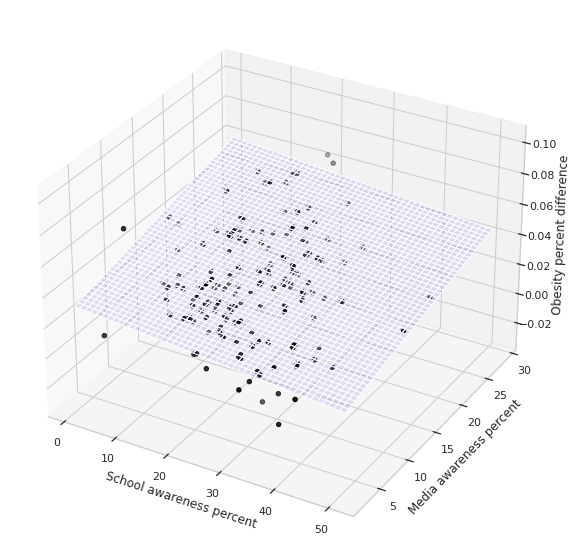

In [161]:
# Step 9: Plot OLS graph
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn
import matplotlib.lines as mlines

sn.set(style = "whitegrid")

#Variables
x= coursework_csv['school_awareness_percent']
y= coursework_csv['media_awareness_percent']
z= coursework_csv['obesity_percent_difference']

# For the scatter plot
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')
ax.set_xlabel('School awareness percent')
ax.set_ylabel('Media awareness percent')
ax.set_zlabel('Obesity percent difference')

# To determine the plane of best fit
xModel = np.linspace(min(x), max(x))
yModel = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xModel, yModel)
Z = 0.0296 -0.0003*X + 0.0011*Y

#Plotting the plane of best fit and the scatter plot
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.1, color='blue')
ax.scatter(x,y,z, color='black')
plt.show()

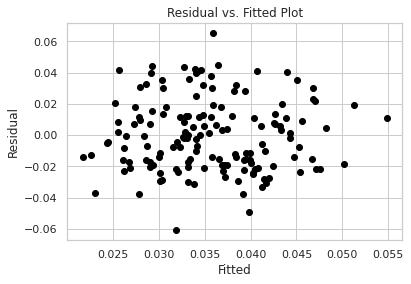

In [157]:
# Step 10: Assess the viability of linear regression by checking to see if the LINE conditions are satisfied, to do this a residual vs fir plot is drawn
plt.scatter(stats.fittedvalues, stats.resid, color='black')
# adding title and labels
plt.xlabel('Fitted')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot')
plt.show()